In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split , cross_validate
from sklearn.metrics import classification_report , confusion_matrix , roc_curve , auc
from sklearn.preprocessing import StandardScaler , FunctionTransformer , OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [27]:
train_df = pd.read_csv('../data/customer_churn_dataset-training-master.csv')
train_df.head()

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0


In [28]:
train_df.dropna(inplace=True)
X = train_df.drop(columns=['CustomerID' , 'Churn'] , axis=1)
Y = train_df.Churn

In [ ]:
# def make_pipeline(base_model , data_path , random_state=42 , test_size = 0.2):
#     data = pd.read_csv(data_path)
#     data.dropna(inplace=True)
#     X = data.drop(columns=['CustomerID' , 'Churn'] , axis=1)
#     Y = data.Churn

#     num_col = [col for col in X.columns if X[col].dtype != 'O']
#     cat_col = [col for col in X.columns if X[col].dtype == 'O']

#     pre = ColumnTransformer(transformers=[('scale' , StandardScaler() , num_col) , ('le', OneHotEncoder(sparse=False, handle_unknown='ignore') , cat_col)])

#     pipeline = Pipeline(steps=[('preprocessor' , pre) , ('model' , base_model)])


#     x_train , x_test , y_train , y_test = train_test_split(X , Y , test_size = 0.2 , random_state = 42)

#     return pipeline , x_train , x_test , y_train , y_test

In [ ]:
def make_pipeline(base_model , X , Y , random_state=42 , test_size = 0.2):

    num_col = [col for col in X.columns if X[col].dtype != 'O']
    cat_col = [col for col in X.columns if X[col].dtype == 'O']

    pre = ColumnTransformer(transformers=[('scale' , StandardScaler() , num_col) , ('le', OneHotEncoder(sparse=False, handle_unknown='ignore') , cat_col)])

    pipeline = Pipeline(steps=[('preprocessor' , pre) , ('model' , base_model)])


    x_train , x_test , y_train , y_test = train_test_split(X , Y , test_size = 0.2 , random_state = 42)

    return pipeline , x_train , x_test , y_train , y_test



In [30]:
def train_model(pipeline, x_train, y_train):
    pipeline.fit(x_train, y_train)

    # Extract transformed feature names
    preprocessor = pipeline.named_steps['preprocessor']
    
    # Get numeric and one-hot encoded feature names
    num_features = preprocessor.transformers_[0][2]
    cat_encoder = preprocessor.transformers_[1][1]
    cat_features = preprocessor.transformers_[1][2]

    if hasattr(cat_encoder, 'get_feature_names_out'):
        cat_feature_names = cat_encoder.get_feature_names_out(cat_features)
    else:
        # Older versions of sklearn
        cat_feature_names = cat_encoder.get_feature_names(cat_features)

    all_features = list(num_features) + list(cat_feature_names)

    # Get feature importances from final model
    model = pipeline.named_steps['model']
    feature_importances = pd.Series(model.feature_importances_, index=all_features)

    # Plot
    feature_importances.sort_values(ascending=True).plot(kind='barh', figsize=(12, 5), color='skyblue')
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Feature')
    plt.title(f'Feature Importances - {type(model).__name__}')
    plt.tight_layout()
    plt.show()

    joblib.dump(pipeline, f'{type(model).__name__}.joblib')

    return pipeline


In [31]:
def show_results(model , x_test , y_test , threshold=0.5):
    
    y_pred_probs = model.predict_proba(x_test)[:, 1]
    y_pred = (y_pred_probs > threshold).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve')
    plt.legend(); plt.grid(); plt.show()

    

    print("\n📊 Classification Report:")
    print(classification_report(y_test, y_pred))

def Cv_results(model, X, Y, cv=5):
    scores = cross_validate(model, X, Y, cv=cv, scoring=['accuracy', 'f1', 'roc_auc', 'precision', 'recall'])
    df = pd.DataFrame(scores)
    return df

In [32]:
def train_and_evaluate_model(base_model , X , Y , random_state=42 , test_size=0.2 ):

    pipeline , x_train , x_test , y_train , y_test = make_pipeline(base_model , X=X , Y=Y , random_state=random_state , test_size=test_size)

    model = train_model(pipeline=pipeline , x_train=x_train , y_train=y_train)
    
    show_results(model=model , x_test=x_test , y_test=y_test)

    df = Cv_results(model=model , X=X , Y=Y )
    return df

c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


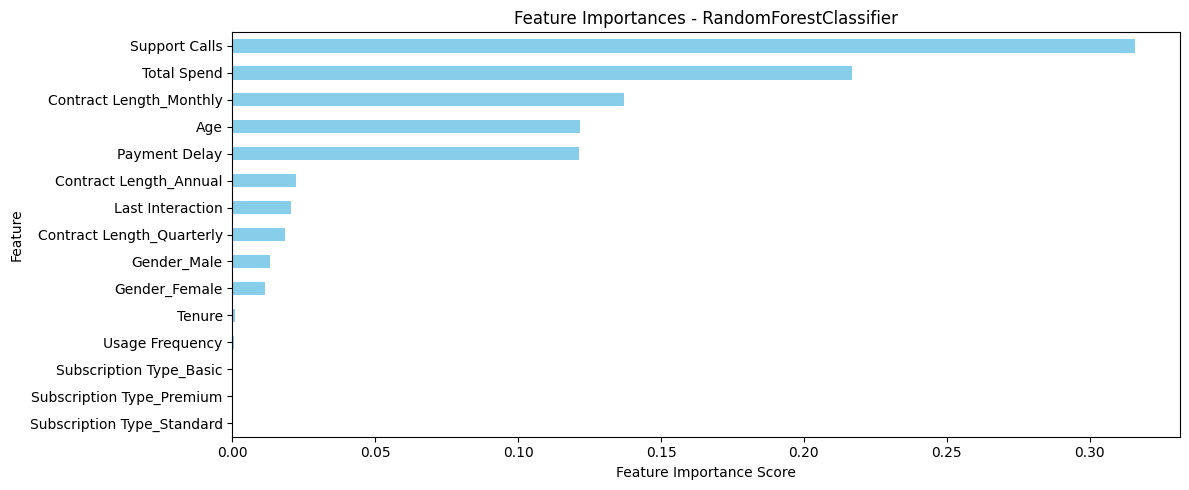

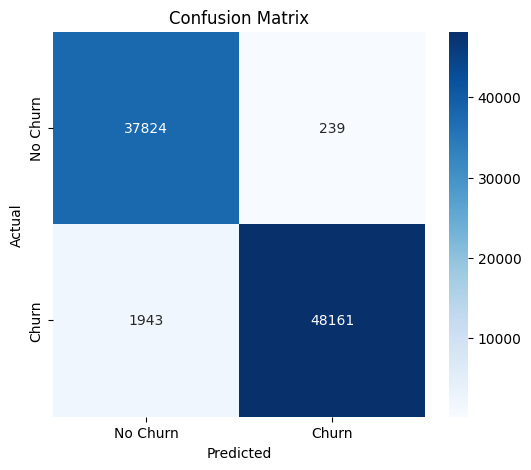

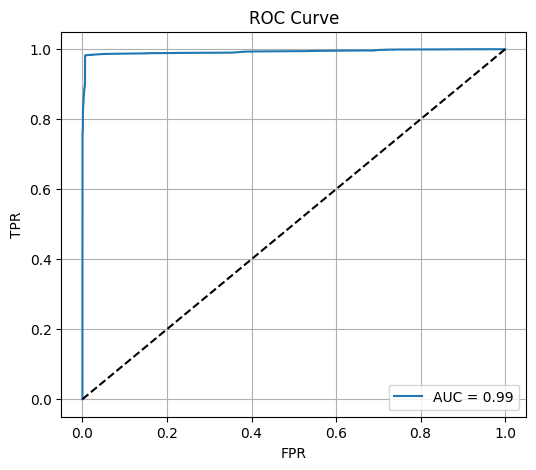


📊 Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     38063
         1.0       1.00      0.96      0.98     50104

    accuracy                           0.98     88167
   macro avg       0.97      0.98      0.97     88167
weighted avg       0.98      0.98      0.98     88167



c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\

,fit_time,score_time,test_accuracy,test_f1,test_roc_auc,test_precision,test_recall
0,42.728191,1.714293,0.974991,0.977568,0.993623,0.994823,0.960900
1,23.656995,1.664980,0.974855,0.977445,0.992463,0.994699,0.960780
2,22.830869,1.599791,0.975909,0.978418,0.993097,0.994444,0.962900
3,23.296832,1.699413,0.975841,0.978348,0.992980,0.994791,0.962440
4,21.896938,1.650228,0.975183,0.977765,0.992474,0.993885,0.962159


In [8]:
train_and_evaluate_model(base_model=RandomForestClassifier(n_estimators=200 , max_depth=4 , min_samples_split=3 , random_state=42) , X=X , Y=Y , random_state=42 , test_size=0.2)

c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


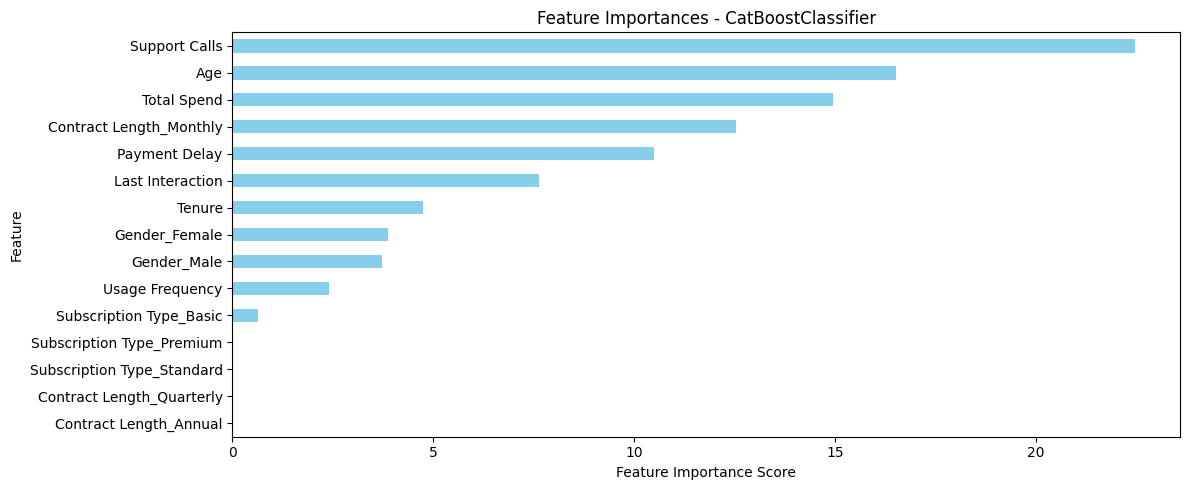

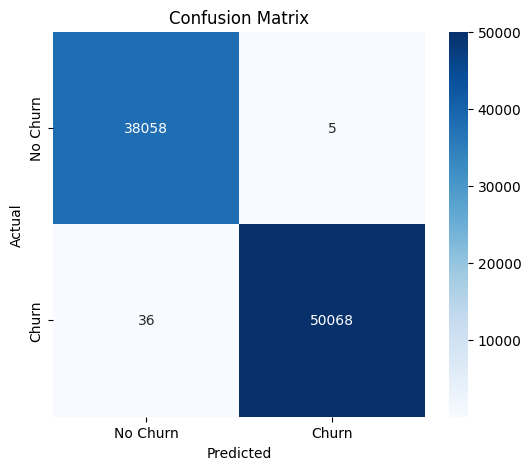

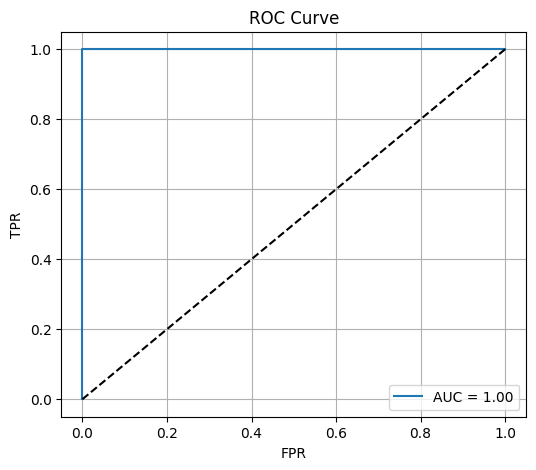


📊 Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     38063
         1.0       1.00      1.00      1.00     50104

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167



c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\

,fit_time,score_time,test_accuracy,test_f1,test_roc_auc,test_precision,test_recall
0,7.787639,1.500990,0.999660,0.99970,0.999999,0.99996,0.99944
1,7.787740,1.541243,0.999376,0.99945,0.999998,0.99996,0.99894
2,7.542180,1.609632,0.999637,0.99968,0.999999,0.99986,0.99950
3,7.779270,1.565488,0.999524,0.99958,0.999999,0.99998,0.99918
4,7.867296,1.652121,0.999546,0.99960,0.999999,1.00000,0.99920


In [9]:
train_and_evaluate_model(base_model=CatBoostClassifier(verbose=0 , task_type='GPU' , eval_metric='Recall' , random_state=42 , iterations=300 , learning_rate=0.05) , X=X , Y=Y , random_state=42 , test_size=0.2)

c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:158: UserWarning: [14:58:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


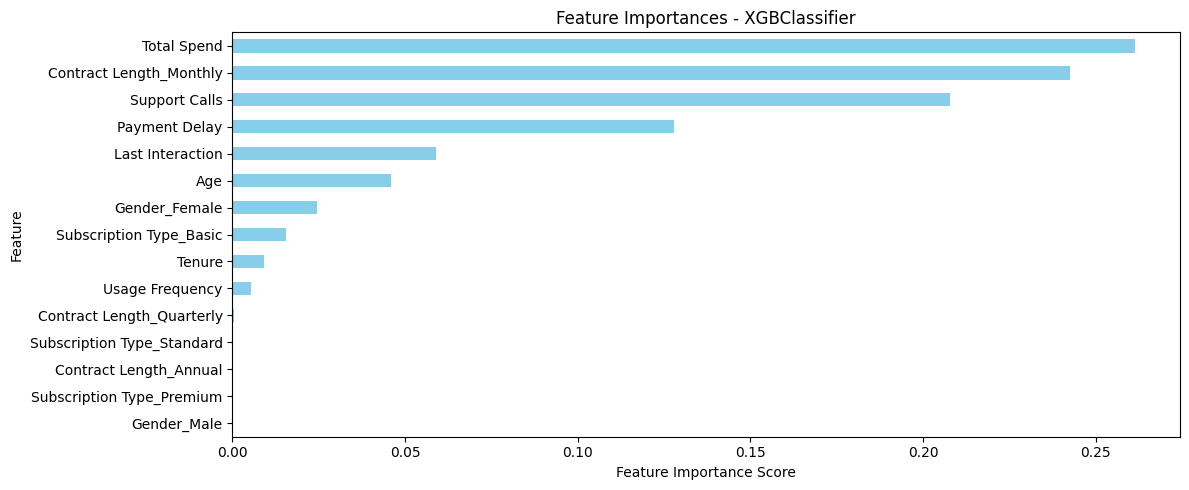

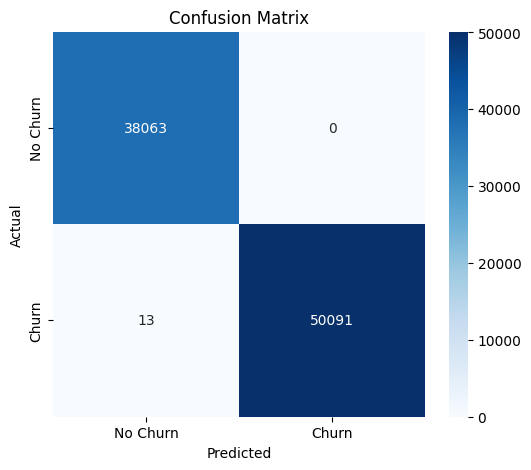

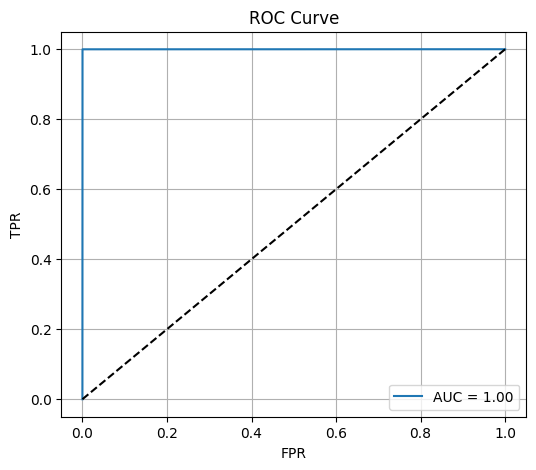


📊 Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     38063
         1.0       1.00      1.00      1.00     50104

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167



c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:158: UserWarning: [14:58:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\T A T\AppData\Local\Programs\Python\Pyt

,fit_time,score_time,test_accuracy,test_f1,test_roc_auc,test_precision,test_recall
0,7.302825,0.862585,0.999773,0.99980,0.999999,1.0,0.99960
1,7.208441,0.911721,0.999841,0.99986,0.999999,1.0,0.99972
2,7.179851,0.877401,0.999909,0.99992,1.000000,1.0,0.99984
3,7.579719,0.349685,0.999864,0.99988,1.000000,1.0,0.99976
4,2.531957,0.316367,0.999966,0.99997,1.000000,1.0,0.99994


In [10]:
train_and_evaluate_model(base_model= XGBClassifier(
    n_estimators=300,        # تعداد درخت‌ها
    learning_rate=0.05,       # نرخ یادگیری
    max_depth=6,             # بیشینه عمق هر درخت
    subsample=0.8,           # درصد نمونه‌گیری از داده‌ها برای هر درخت
    gamma=0,                 # حداقل کاهش لازم برای تقسیم گره
    reg_alpha=0,             # L1 regularization term
    reg_lambda=1,            # L2 regularization term
    use_label_encoder=False, # جلوگیری از اخطار نسخه‌های قدیمی
    eval_metric='logloss',   # معیار ارزیابی
    random_state=42          # بازتولیدپذیری
) , X=X , Y=Y , random_state=42 , test_size=0.2)

c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Number of positive: 199895, number of negative: 152770
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 352665, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.566813 -> initscore=0.268859
[LightGBM] [Info] Start training from score 0.268859


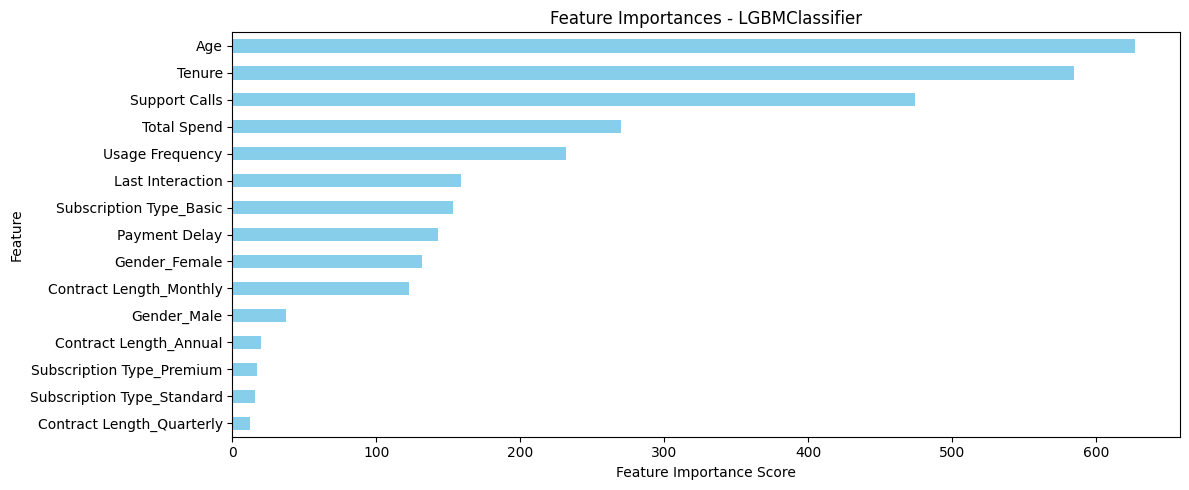

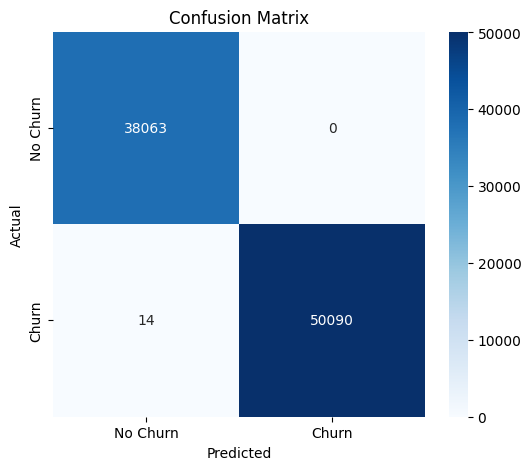

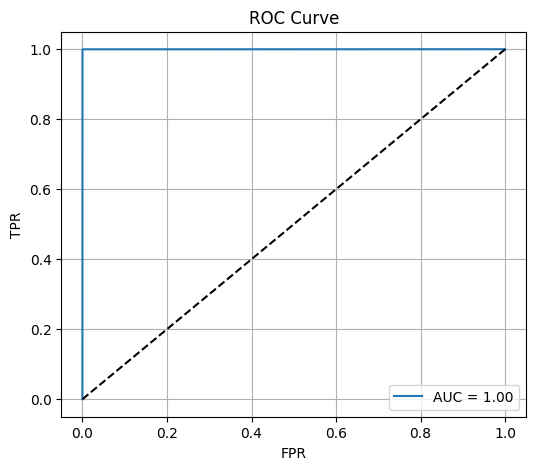


📊 Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     38063
         1.0       1.00      1.00      1.00     50104

    accuracy                           1.00     88167
   macro avg       1.00      1.00      1.00     88167
weighted avg       1.00      1.00      1.00     88167



c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Number of positive: 199999, number of negative: 152666
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001820 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 352665, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.567108 -> initscore=0.270060
[LightGBM] [Info] Start training from score 0.270060
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Number of positive: 199999, number of negative: 152666
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 352665, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.567108 -> initscore=0.270060
[LightGBM] [Info] Start training from score 0.270060


c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Number of positive: 199999, number of negative: 152667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002285 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 352666, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.567106 -> initscore=0.270053
[LightGBM] [Info] Start training from score 0.270053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Number of positive: 199999, number of negative: 152667
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 352666, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.567106 -> initscore=0.270053
[LightGBM] [Info] Start training from score 0.270053


c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Number of positive: 200000, number of negative: 152666
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 352666, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.567109 -> initscore=0.270065
[LightGBM] [Info] Start training from score 0.270065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,fit_time,score_time,test_accuracy,test_f1,test_roc_auc,test_precision,test_recall
0,0.859122,0.383332,0.999966,0.99997,1.000000,0.99996,0.99998
1,0.881172,0.384298,0.999830,0.99985,1.000000,1.00000,0.99970
2,0.887303,0.362408,0.999943,0.99995,0.999999,1.00000,0.99990
3,0.871764,0.383392,0.999784,0.99981,1.000000,1.00000,0.99962
4,0.916769,0.374036,0.999955,0.99996,1.000000,1.00000,0.99992


In [11]:
lgbm_model = LGBMClassifier(
    n_estimators=100,         # تعداد درخت‌ها
    learning_rate=0.1,        # نرخ یادگیری
    max_depth=-1,             # عمق درخت‌ها (-1 یعنی بدون محدودیت)
    num_leaves=31,            # تعداد برگ‌ها در هر درخت (اثر زیاد بر قدرت مدل)
    subsample=0.8,            # درصد نمونه‌گیری از داده‌ها
    colsample_bytree=0.8,     # درصد ویژگی‌ها برای هر درخت
    reg_alpha=0.0,            # L1 regularization
    reg_lambda=1.0,           # L2 regularization
    min_child_samples=20,     # حداقل تعداد نمونه در یک برگ
    objective='binary',       # نوع مسئله (binary, multiclass, regression)
    boosting_type='gbdt',     # نوع boosting (gbdt, dart, goss)
    random_state=42           # بازتولیدپذیری
)


train_and_evaluate_model(base_model=lgbm_model , X=X , Y=Y , random_state=42 , test_size=0.2 )


In [8]:
model = joblib.load('./XGBClassifier.joblib')

real_df = pd.read_csv('../data/customer_churn_dataset-testing-master.csv')
real_df.dropna(inplace=True)
X = real_df.drop(columns=['CustomerID' , 'Churn'] , axis=1)
Y = real_df.Churn

y_pred = model.predict(X)
print(classification_report(Y , y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     33881
           1       1.00      1.00      1.00     30493

    accuracy                           1.00     64374
   macro avg       1.00      1.00      1.00     64374
weighted avg       1.00      1.00      1.00     64374



In [9]:
real_train , real_test = train_test_split(real_df , stratify=real_df['Churn'] , random_state=42 , test_size=0.5)

X_real_train = real_train.drop(columns=['Churn' , 'CustomerID'])
y_real_train = real_train['Churn']

In [12]:
from sklearn.model_selection import train_test_split
import joblib
import xgboost as xgb

# 1. تقسیم stratified دیتاست واقعی
real_train, real_test = train_test_split(
    real_df,
    stratify=real_df['Churn'],
    test_size=0.5,
    random_state=42
)

# 2. آماده‌سازی X و y برای آموزش
X_real_train = real_train.drop(columns=['Churn', 'CustomerID'])
y_real_train = real_train['Churn']

# --- تابع فاین‌تیون pipeline ---
def finetune_pipeline(pipeline_path, X_new, y_new, num_boost_round=50, save_path=None):
    pipeline = joblib.load(pipeline_path)
    preprocessor = pipeline.named_steps["preprocessor"]
    xgb_model = pipeline.named_steps["model"]

    # اعمال پیش‌پردازش روی داده جدید
    X_new_processed = preprocessor.transform(X_new)

    # تبدیل به DMatrix
    dnew = xgb.DMatrix(X_new_processed, label=y_new)

    # استخراج booster فعلی
    booster = xgb.Booster()
    booster.load_model(xgb_model.get_booster().save_raw())

    # ادامه آموزش (فاین‌تیون)
    booster = xgb.train(
        params=xgb_model.get_xgb_params(),
        dtrain=dnew,
        num_boost_round=num_boost_round,
        xgb_model=booster
    )

    # به‌روزرسانی مدل در pipeline
    xgb_model._Booster = booster
    xgb_model.n_estimators += num_boost_round
    pipeline.steps[-1] = ('classifier', xgb_model)

    # ذخیره pipeline فاین‌تیون شده
    if save_path:
        joblib.dump(pipeline, save_path)

    return pipeline

# 3. فاین‌تیون pipeline با داده واقعی
pipeline_finetuned = finetune_pipeline(
    pipeline_path='./XGBClassifier.joblib',
    X_new=X_real_train,
    y_new=y_real_train,
    num_boost_round=50,
    save_path='pipeline_finetuned.pkl'
)

print("فاین‌تیون انجام شد و pipeline ذخیره شد.")

فاین‌تیون انجام شد و pipeline ذخیره شد.


c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\xgboost\core.py:158: UserWarning: [15:39:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [13]:
X_real_test = real_test.drop(columns=['Churn', 'CustomerID'])
y_real_test = real_test['Churn']

y_pred = pipeline_finetuned.predict(X_real_test)

In [14]:
print(classification_report(y_real_test , y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     16941
           1       1.00      1.00      1.00     15246

    accuracy                           1.00     32187
   macro avg       1.00      1.00      1.00     32187
weighted avg       1.00      1.00      1.00     32187



In [19]:
X_train = train_df.drop(columns=['Churn', 'CustomerID'])
y_train = train_df['Churn']

In [20]:
y_pred_train = pipeline_finetuned.predict(X_train)

In [22]:
print(classification_report(y_train , y_pred_train))


              precision    recall  f1-score   support

         0.0       0.51      0.99      0.67    190833
         1.0       0.98      0.27      0.42    249999

    accuracy                           0.58    440832
   macro avg       0.75      0.63      0.55    440832
weighted avg       0.78      0.58      0.53    440832



c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Number of positive: 224431, number of negative: 179733
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 404164, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.555297 -> initscore=0.222096
[LightGBM] [Info] Start training from score 0.222096


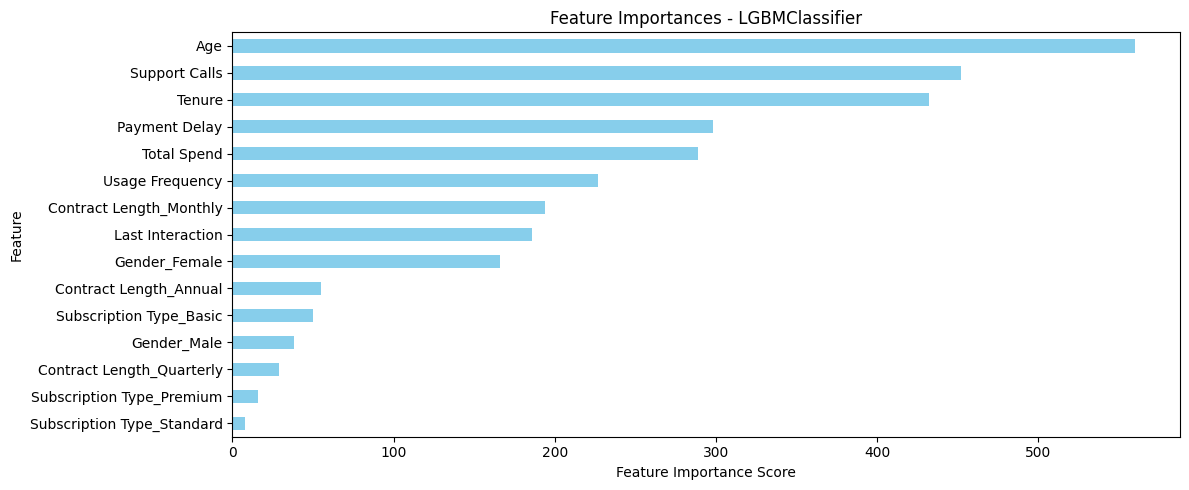

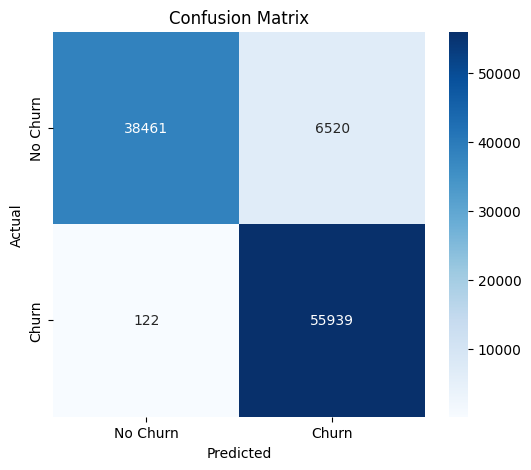

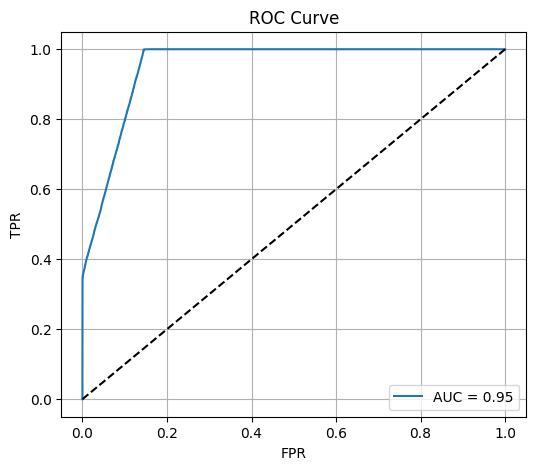


📊 Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.86      0.92     44981
         1.0       0.90      1.00      0.94     56061

    accuracy                           0.93    101042
   macro avg       0.95      0.93      0.93    101042
weighted avg       0.94      0.93      0.93    101042



c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Number of positive: 224393, number of negative: 179771
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002332 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 404164, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.555203 -> initscore=0.221715
[LightGBM] [Info] Start training from score 0.221715


c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Number of positive: 224393, number of negative: 179772
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002487 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 404165, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.555201 -> initscore=0.221710
[LightGBM] [Info] Start training from score 0.221710


c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Number of positive: 224394, number of negative: 179771
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 404165, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.555204 -> initscore=0.221720
[LightGBM] [Info] Start training from score 0.221720


c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Number of positive: 224394, number of negative: 179771
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007614 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 404165, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.555204 -> initscore=0.221720
[LightGBM] [Info] Start training from score 0.221720


c:\Users\T A T\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[LightGBM] [Info] Number of positive: 224394, number of negative: 179771
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001928 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 487
[LightGBM] [Info] Number of data points in the train set: 404165, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.555204 -> initscore=0.221720
[LightGBM] [Info] Start training from score 0.221720


,fit_time,score_time,test_accuracy,test_f1,test_roc_auc,test_precision,test_recall
0,0.999238,0.371825,0.998565,0.998706,0.999998,1.000000,0.997415
1,0.940219,0.376659,0.998723,0.998849,0.999997,1.000000,0.997700
2,1.060291,0.380971,0.998644,0.998777,0.999997,1.000000,0.997558
3,1.079886,0.393532,0.998436,0.998590,0.999996,1.000000,0.997184
4,0.981319,0.377850,0.683544,0.778067,0.732430,0.637098,0.999144


In [33]:


# 1. حذف ستون CustomerID از هر دو دیتاست
train_clean = train_df.drop(columns=['CustomerID'])
real_clean = real_df.drop(columns=['CustomerID'])

# 2. ادغام دیتاست‌ها
combined_df = pd.concat([train_clean, real_clean], axis=0).reset_index(drop=True)

# 3. جدا کردن X و y
X = combined_df.drop(columns=['Churn'])
y = combined_df['Churn']

# 4. تقسیم به train و validation (اختیاری)
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    stratify=y,
    test_size=0.2,
    random_state=42
)
lgbm_model = LGBMClassifier(
    n_estimators=100,         # تعداد درخت‌ها
    learning_rate=0.1,        # نرخ یادگیری
    max_depth=-1,             # عمق درخت‌ها (-1 یعنی بدون محدودیت)
    num_leaves=31,            # تعداد برگ‌ها در هر درخت (اثر زیاد بر قدرت مدل)
    subsample=0.8,            # درصد نمونه‌گیری از داده‌ها
    colsample_bytree=0.8,     # درصد ویژگی‌ها برای هر درخت
    reg_alpha=0.0,            # L1 regularization
    reg_lambda=1.0,           # L2 regularization
    min_child_samples=20,     # حداقل تعداد نمونه در یک برگ
    objective='binary',       # نوع مسئله (binary, multiclass, regression)
    boosting_type='gbdt',     # نوع boosting (gbdt, dart, goss)
    random_state=42           # بازتولیدپذیری
)


train_and_evaluate_model(base_model=lgbm_model , X=X , Y=y , random_state=42 , test_size=0.2 )